# Predicting NBA Scores using Machine Learning

### George Tao,  Jeremiah Sahabu, Isaac Chau

#### Introduction

Sports inheritantly has large variability. Thus, we wanted to see if we can predict which team will win through supervised Machine Learning. We decided to use Logistic Regression for our models as we believe it fits the scenario best.

#### Dataset:

#### Features:

We saw a lot of features given ranging from player stats, scores, among others. We used a combination of these features as well as features we created from the dataset above to feed into our model. See list below of features we identified significant

- Consecutive Away Games
- Wins in the last 10 Games
- Officials 
- Players
- Back to Back Games
- eFG% (season average)
- eFG% allowed (season average)
- Team Fouls (season average)
- Turnovers 
- Offensive Rebounds



### Libraries

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statistics import median

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
from datetime import datetime, timedelta, date

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
import nltk
import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.colors import LogNorm


### Loading in the Data

In [2]:
teamBoxScore = pd.read_csv("nba-enhanced-stats/2012-18_teamBoxScore.csv")
playerBoxScore = pd.read_csv("nba-enhanced-stats/2012-18_playerBoxScore.csv")
standings = pd.read_csv("nba-enhanced-stats/2012-18_standings.csv")
teamResult = teamBoxScore['teamRslt']

### Parsing the Data

#### Officials

In [5]:
#Fill a list with names of officials.
off_set = set()

for row in teamBoxScore.iterrows():
    off1 = str(row[1]['offFNm1'] + ' ' + row[1]['offLNm1'])
    off_set.add(off1)
    
    off2 = str(row[1]['offFNm2']) + ' ' + str(row[1]['offLNm2'])
    off_set.add(off2)
    
    off3 = str(row[1]['offFNm3']) + ' ' + str(row[1]['offLNm3'])
    off_set.add(off3)
    
off_list = list(sorted(off_set))
off_len = len(off_list)

# Create a one-hot matrix of which officials officiated which games
# Each game indicates a unique game
# 1 indicates a game an official worked in
off_matrix = np.empty((int(len(teamBoxScore.index) / 2), off_len))

count = -1
for row in teamBoxScore.iterrows():
    count += 1
    
    #managing repeating games
    if count % 2 == 1:
        continue

    off1 = str(row[1]['offFNm1'] + ' ' + row[1]['offLNm1'])
    off1_index = off_list.index(off1)

    off2 = str(row[1]['offFNm2']) + ' ' + str(row[1]['offLNm2'])
    off2_index = off_list.index(off2)
    
    off3 = str(row[1]['offFNm3']) + ' ' + str(row[1]['offLNm3'])
    off3_index = off_list.index(off3)
    
    off_matrix[count // 2][off1_index] = 1
    off_matrix[count // 2][off2_index] = 1
    off_matrix[count // 2][off3_index] = 1
    
off_df = pd.DataFrame(off_matrix, columns = off_list)
off_df.head()

,Aaron Smith,Ben Taylor,Bennett Salvatore,Bennie Adams,Bill Kennedy,Bill Spooner,Brandon Adair,Brenda Pantoja,Brent Barnaky,Brett Nansel,...,Steven Anderson,Tom Washington,Tony Brothers,Tony Brown,Tre Maddox,Tyler Ford,Violet Palmer,Vladimir Voyard-Tadal,Zach Zarba,nan nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Players

In [7]:
#Fill a list with names of players.
player_set = set()

for row in playerBoxScore.iterrows():
    player = str(row[1]['playFNm'] + ' ' + row[1]['playLNm'])
    player_set.add(player)
    
temp_list = list(sorted(player_set))

player_list = []
for player in temp_list:
    player_list.append(player)
    player_list.append(player + " - Away")
    
player_len = len(player_list)

# Create a matrix of which players played in which games
# 1 indicates a player playing in the game
player_matrix = np.empty((int(len(teamBoxScore.index) / 2), player_len))

count = -1
current_team = 'wow I really enjoyed this course Amit'
for row in playerBoxScore.iterrows():
    if row[1]['teamAbbr'] != current_team:
        current_team = row[1]['teamAbbr']
        count += 1
    player = str(row[1]['playFNm'] + ' ' + row[1]['playLNm'])
    player_index = player_list.index(player)
    
    if row[1]['teamLoc'] == 'Home':
        player_matrix[count // 2][player_index] = 1
    else:
        player_matrix[count // 2][player_index + 1] = 1
    
player_df = pd.DataFrame(player_matrix, columns = player_list)
player_df.head()

,A.J. Price,A.J. Price - Away,Aaron Brooks,Aaron Brooks - Away,Aaron Gordon,Aaron Gordon - Away,Aaron Gray,Aaron Gray - Away,Aaron Hammons,Aaron Hammons - Away,...,Zach Randolph,Zach Randolph - Away,Zachary LaVine,Zachary LaVine - Away,Zaza Pachulia,Zaza Pachulia - Away,Zhou Qi,Zhou Qi - Away,Zoran Dragić,Zoran Dragić - Away
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Game Stats

In [8]:
# Find EFG% for each team in the season leading up to a game
# Do this by tracking their FGM, 3PM, and FGA

#Creating a list of names
team_names_set = set()
for row in teamBoxScore.iterrows():
    team_names_set.add(row[1]['teamAbbr'])
    team_names_set.add(row[1]['opptAbbr'])
    
    if len(team_names_set) == 30:
        break
team_names_list = list(sorted(team_names_set))

#matrix keeping track of efg before every game
efg_matrix = np.zeros((len(teamBoxScore.index) // 2, 10))
efg_columns_list = ['teamEFG%', 'opptEFG%','teamEFG%A', 'opptEFG%A','teamPF', 'opptPF',
                    'teamTO', 'opptTO', 'teamOREB', 'opptOREB']

#matrix calculating each team's cumulative EFG%
team_stats_matrix = np.zeros((30, 11)) ###(ADJUSTABLE)

prev_date = datetime.strptime('2012-10-29', "%Y-%m-%d")
count = -1
for row in teamBoxScore.iterrows():
    count += 1
    
    #managing repititons
    if row[1]['teamLoc'] == 'Away':
        continue
    
    #finding index of the two teams playing
    team = row[1]['teamAbbr']
    oppt = row[1]['opptAbbr']
    team_index = team_names_list.index(team)
    oppt_index = team_names_list.index(oppt)
    
    #helper function that accesses the team_stats_matrix
    team_row = team_stats_matrix[team_index]
    oppt_row = team_stats_matrix[oppt_index]
    
    #updating efg_matrix
    efg_matrix[count // 2][0] = team_row[3]
    efg_matrix[count // 2][2] = team_row[7]
    efg_matrix[count // 2][4] = team_row[8]
    efg_matrix[count // 2][6] = team_row[9]
    efg_matrix[count // 2][8] = team_row[10]
    efg_matrix[count // 2][1] = oppt_row[3]
    efg_matrix[count // 2][3] = oppt_row[7]
    efg_matrix[count // 2][5] = oppt_row[8]
    efg_matrix[count // 2][7] = oppt_row[9]
    efg_matrix[count // 2][9] = oppt_row[10]

    #updating team_stats_matrix for this game
    team_row[0] += row[1]['teamFGM']
    team_row[1] += row[1]['team3PM']
    team_row[2] += row[1]['teamFGA']
    team_row[3] = (team_row[0] + 0.5 * (team_row[1])) / team_row[2] #teamEFG%
    team_row[4] += row[1]['opptFGM']
    team_row[5] += row[1]['oppt3PM']
    team_row[6] += row[1]['opptFGA']
    team_row[7] = (team_row[4] + 0.5 * (team_row[5])) / team_row[6] #teamEFG%A
    team_row[8] += row[1]['teamPF'] #teamPF
    team_row[9] += row[1]['teamTO'] #teamTO
    team_row[10] += row[1]['teamORB'] #teamOREB
    
    oppt_row[0] += row[1]['opptFGM']
    oppt_row[1] += row[1]['oppt3PM']
    oppt_row[2] += row[1]['opptFGA']
    oppt_row[3] = (oppt_row[0] + 0.5 * (oppt_row[1])) / oppt_row[2] #opptEFG%
    oppt_row[4] += row[1]['teamFGM']
    oppt_row[5] += row[1]['team3PM']
    oppt_row[6] += row[1]['teamFGA']
    oppt_row[7] = (oppt_row[4] + 0.5 * (oppt_row[5])) / oppt_row[6] #opptEFG%A
    oppt_row[8] += row[1]['opptPF'] #opptPF
    oppt_row[9] += row[1]['opptTO'] #opptTO
    oppt_row[10] += row[1]['opptORB'] #opptORB
    
    
    # THIS CHECKS FOR A NEW SEASON
    # IF IT'S A NEW SEASON, WE RESET THE team_stats_matrix
    current_date = datetime.strptime(row[1]['gmDate'], "%Y-%m-%d")
    if (current_date - prev_date).days > 90:
        team_stats_matrix = np.zeros((30, 11)) ###(ADJUSTABLE)

    prev_date = current_date

column_names = ['FGM', '3PM', 'FGA', 'EFG%', 'FGMA', '3PMA', 'FGAA', 'EFG%A', 'PF', 'TO', 'ORB']
totals_df = pd.DataFrame(team_stats_matrix, index = team_names_list, columns = column_names)

#loading efg_matrix data onto a dataframe
stats_df = pd.DataFrame(efg_matrix, columns = efg_columns_list)
stats_df.tail()

,teamEFG%,opptEFG%,teamEFG%A,opptEFG%A,teamPF,opptPF,teamTO,opptTO,teamOREB,opptOREB
7374,0.512067,0.526666,0.526119,0.522674,1552.0,1721.0,1178.0,1188.0,717.0,804.0
7375,0.534821,0.532306,0.492390,0.527453,1794.0,1735.0,1344.0,1113.0,876.0,680.0
7376,0.527256,0.516550,0.519144,0.514405,1621.0,1713.0,1192.0,1279.0,824.0,866.0
7377,0.511004,0.528627,0.504315,0.506404,1577.0,1589.0,1101.0,1194.0,828.0,725.0
7378,0.502292,0.551899,0.543446,0.521482,1625.0,1573.0,1116.0,1131.0,771.0,731.0


#### Back to Back Status & Consecutive Away Games Counter

In [9]:
# Get back to back status for each team as well as consecutive away games

#Start with teamBoxScore 
teams = teamBoxScore[["teamAbbr", "teamLoc", "teamRslt", "gmDate"]]

#convert gmDate into date object
def make_date(x):
    return datetime.strptime(x, '%Y-%m-%d').date()

#add datetime column, drop date strings column
gmDate_date = list(map(make_date, teams['gmDate']))
teams['gmDate_date'] = gmDate_date
teams.drop(['gmDate'], axis = 1, inplace = True)

sorted_teams = teams.groupby('teamAbbr')
sorted_teams.first()

# Build a dictionary with keys being the teams
team_names = list(teamBoxScore.teamAbbr.unique())
team_dict = {}
for teams in team_names:
    xx = sorted_teams.get_group(teams)
    xx = xx.reset_index()
    
    for ind, row in xx.iterrows():
        if ind == 0:
            xx.loc[ind, "back_to_back"] = 0
        else:
            if row['gmDate_date'] == (xx.loc[ind-1,'gmDate_date'] + timedelta(days=1)):
                xx.loc[ind, "back_to_back"] = 1
            else:
                xx.loc[ind, "back_to_back"] = 0

    Counter = 0            
    for ind, row in xx.iterrows():
        if row['teamLoc'] == "Away":
            Counter += 1
            xx.loc[ind, "consecutive_away_games"] = Counter
        else:
            Counter = 0
            xx.loc[ind, "consecutive_away_games"] = Counter
    
    team_dict[teams] = xx

# Combine the values in dictionary and then sort them back into order
frames = []
for abbr in list(team_dict.keys()):
    frames.append(team_dict[abbr][['index','back_to_back',"consecutive_away_games"]])

result = pd.concat(frames)
result = result.sort_values('index')
result.set_index('index', inplace = True)

#Combining to teamBoxScore
newBox = pd.concat([ teamBoxScore, result[['back_to_back','consecutive_away_games']] ], axis=1, sort=False)

#delete duplicates/repetitions
testBox = newBox
for row in testBox.itertuples():
    if row[13] == 'Away':
        testBox.drop([row[0]], inplace = True)

C:\Users\georg\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\georg\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
#run once only
testBox.reset_index(inplace=True)
b2b_df = testBox['back_to_back']
away_streak_df = testBox['consecutive_away_games']

team_result_df = pd.DataFrame(testBox['teamRslt'])
win_loss = []
for row in team_result_df.itertuples():
    if row[1] == 'Win':
        win_loss.append(1)
    else:
        win_loss.append(0)

#### Wins In Last 10 Games & Consecutive Away Games Counter

In [11]:
def x_days_before(s, x):
    date = datetime.strptime(s, "%Y-%m-%d")
    modified_date = date - timedelta(days=x)
    return modified_date

#Parsing Data and Finding Consequetive Away Games
teams = teamBoxScore[["teamAbbr", "teamAbbr", "teamLoc", "teamRslt", "gmDate"]]
teams.columns = ["groups", "teamAbbr", "teamLoc", "teamRslt", "gmDate"]

#Grouping Data by Team
sorted_teams = teams.groupby('groups')
sorted_teams.first()

#Finding Consequetive Away Games
for teams in team_names:
    temp = sorted_teams.get_group(teams)
    temp = temp.reset_index()
    Counter = 0
    for ind, row in temp.iterrows():
        if row['teamLoc'] == "Away":
            Counter += 1
            temp.loc[ind, "Consecutive_Away_Games"] = Counter
        else:
            Counter = 0
            temp.loc[ind, "Consecutive_Away_Games"] = Counter
    team_dict[teams] = temp

#Finding Number of Wins in Past 10 Games

    for ind in temp.index:
        if ind < 10:
            Counter = 0
            for x in range(ind):
                if temp['teamRslt'][x] == "Win":
                    Counter += 1
            temp.loc[ind, "wins_in_last_10"] = Counter
        else:
            Counter = 0
            for x in range(ind-10,ind):
                if temp['teamRslt'][x] == "Win":
                    Counter += 1
            temp.loc[ind, "wins_in_last_10"] = Counter

#Combining the Tables 
final_1 = pd.concat([team_dict['ATL'], team_dict['BKN'], team_dict['BOS'], team_dict['CHA'], team_dict['CHI'], team_dict['CLE'], team_dict['DAL'], team_dict['DEN'], team_dict['DET'], team_dict['GS']], ignore_index=True)
final_2 = pd.concat([team_dict['HOU'], team_dict['IND'], team_dict['LAC'], team_dict['LAL'], team_dict['MEM'], team_dict['MIA'], team_dict['MIL'], team_dict['MIN'], team_dict['NO'], team_dict['NY']], ignore_index=True)
final_3 = pd.concat([team_dict['OKC'], team_dict['ORL'], team_dict['PHI'], team_dict['PHO'], team_dict['POR'], team_dict['SA'], team_dict['SAC'], team_dict['TOR'], team_dict['UTA'], team_dict['WAS']], ignore_index=True)

final = pd.concat([final_1, final_2, final_3], ignore_index=True)

final = final.sort_values('index')
wins_10_df = final.set_index('index')

#Color Scheme
for ind, row in final.iterrows():
    if row["teamRslt"] == "Win":
        wins_10_df.loc[ind, "color_scheme"] = 0
    else:
        wins_10_df.loc[ind, "color_scheme"] = 1

#delete duplicated games
for row in wins_10_df.itertuples():
    if row[2] == 'Away':
        wins_10_df.drop([row[0]], inplace = True)

#reset index
wins_10_df.reset_index(inplace=True)

#### Games Ahead

In [12]:
# Dataframe comparing the two teams records
# This will just be one column titled "Games Ahead" describing how many games ahead the home team is from the away team
# EG: Home: 26-13 Away: 22-16 
#     Games Ahead = ((26-13) - (22 - 16)) / 2 = 3.5

# pull standings data: we want date, teamAbbr, wins, losses
# for each game played,
# look at standings for home team and away team for the PREVIOUS DAY
# calculate Games Ahead
# put into new dataframe
# count = 0
games_ahead_list = []

temp_standings = standings[['stDate', 'teamAbbr', 'gameWon', 'gameLost']]
for row in teamBoxScore.iterrows():
    if row[1]['teamLoc'] == 'Away':
        continue
    else:
        date = row[1]['gmDate']
        day_before = x_days_before(date, 1)
        first_date = datetime.strptime(temp_standings.iloc[0]['stDate'], "%Y-%m-%d")

        if day_before > first_date:
            for i in range(30):
                temp_standings = temp_standings.drop(temp_standings.index[0])
                
        first_date = datetime.strptime(temp_standings.iloc[0]['stDate'], "%Y-%m-%d")

        team1 = row[1]['teamAbbr']
        team2 = row[1]['opptAbbr']
        
        games_ahead = 0
        
        if day_before == first_date:
            dayb4 = datetime.strftime(day_before, "%Y-%m-%d")
            dayb4_df = temp_standings.loc[temp_standings['stDate'] == dayb4]

            team1Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team1]
            team2Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team2]

            team1Over500 = team1Rec.iloc[0]['gameWon'] - team1Rec.iloc[0]['gameLost']
            team2Over500 = team2Rec.iloc[0]['gameWon'] - team2Rec.iloc[0]['gameLost']
            
            games_ahead = (team1Over500 - team2Over500) / 2
        
        games_ahead_list.append(games_ahead)
        
games_ahead_df = pd.DataFrame(np.array(games_ahead_list), columns = ['gamesAhead'])
games_ahead_df.tail()

,gamesAhead
7374,-19.0
7375,7.0
7376,8.0
7377,0.0
7378,-39.0


#### Combining Features Into One Dataframe

In [13]:
#Combining our dataframes
data_df = pd.concat([off_df, 
                    player_df, 
                    stats_df, 
                    b2b_df, 
                    away_streak_df,
                    wins_10_df['wins_in_last_10'],
                    games_ahead_df], axis=1, sort=False)
data_matrix = np.matrix(data_df)

results_df = teamBoxScore.loc[teamBoxScore['teamLoc'] == 'Home']['teamRslt']
results_array = np.array(results_df)

#### Splitting Data
* Test data: 2018 season
* Dev data: 2017 season
* Training data: 2012-2016 seasons

In [14]:
test_data1, test_labels1 = data_matrix[6149:], results_array[6149:]
dev_data1, dev_labels1 = data_matrix[4919:6149], results_array[4919:6149]
train_data1, train_labels1 = data_matrix[:4919], results_array[:4919]
mini_train_data1, mini_train_labels1 = data_matrix[:1000], results_array[:1000]

### Models & Plots

#### Naive Model: Baseline Accuracy

In [15]:
#Naive Model - predicts team with better record.. if teams are tied, then predicts home team

#for every game in dev_data:
#  if there exists day_before record of both teams:
#    set record1, record2 to be the day_before_record of teams
#  if record1 != record2:
#    predict better record
#  else:
#    predict home team


temp_standings = standings[['stDate', 'teamAbbr', 'gameWon', 'gameLost']]
correct = 0
wrong = 0

for row in teamBoxScore.iterrows():
    date = row[1]['gmDate'] #30
    day_before = x_days_before(date, 1) #29
    first_date = datetime.strptime(temp_standings.iloc[0]['stDate'], "%Y-%m-%d") #30
    
    if day_before > first_date:
        for i in range(30):
            temp_standings = temp_standings.drop(temp_standings.index[0])
    
    team1 = row[1]['teamAbbr']
    team2 = row[1]['opptAbbr']

    if day_before == first_date:
        #FIX THIS
        dayb4 = datetime.strftime(day_before, "%Y-%m-%d")
        dayb4_df = temp_standings.loc[temp_standings['stDate'] == dayb4]
        
        team1Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team1]
        team2Rec = dayb4_df.loc[dayb4_df['teamAbbr'] == team2]
        
        team1Over500 = team1Rec.iloc[0]['gameWon'] - team1Rec.iloc[0]['gameLost']
        team2Over500 = team2Rec.iloc[0]['gameWon'] - team2Rec.iloc[0]['gameLost']
        
        if team1Over500 > team2Over500:
            prediction = 'Win'
        elif team1Over500 < team2Over500:
            prediction = 'Loss'
        elif row[1]['teamLoc'] == 'Home':
            prediction = 'Win'
        else:
            prediction = 'Loss'
    else:
        if row[1]['teamLoc'] == 'Home':
            prediction = 'Win'
        else:
            prediction = 'Loss'
    if prediction == row[1]['teamRslt']:
        correct += 1
    else:
        wrong += 1

print("Accuracy: ", correct / (correct + wrong))


Accuracy:  0.6470388941591001


#### Logistic Regression

C:\Users\georg\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.616283592230735


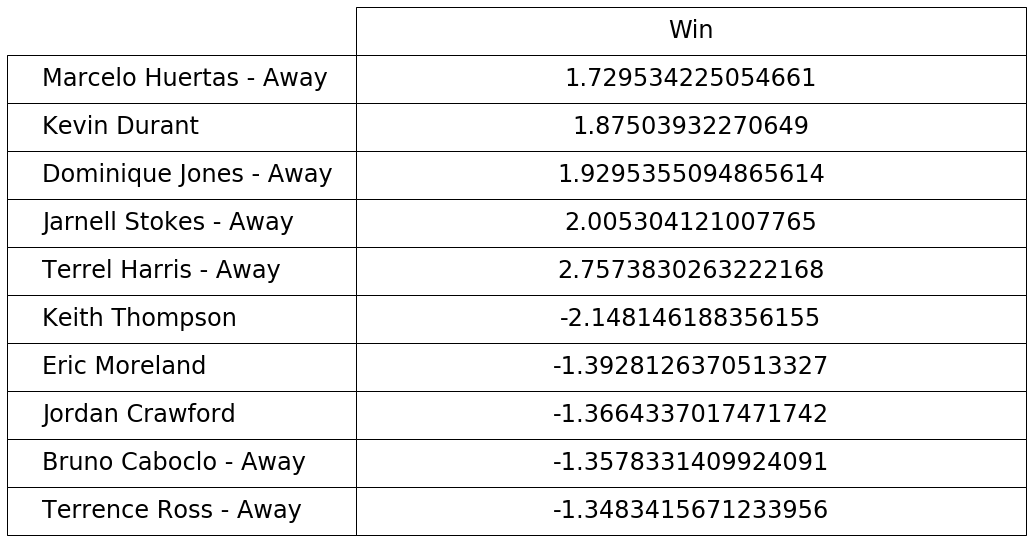

In [16]:
logRegression = LogisticRegression(penalty = 'l1')
logRegression.fit(train_data1, train_labels1)
predictions = logRegression.predict(dev_data1)


score = metrics.f1_score(dev_labels1, predictions, average = "weighted")
print(score)

#Finding most important features in our model and their respective indices
#They get put into the lists, important_features and important_indices
label_weights = logRegression.coef_
features = list(data_df.columns)
important_features = []
important_indices = []

largest_weights = sorted(label_weights[0])[-5:]
largest_weights_indices = [list(label_weights[0]).index(largest_weights[0]), 
                          list(label_weights[0]).index(largest_weights[1]),
                         list(label_weights[0]).index(largest_weights[2]),
                          list(label_weights[0]).index(largest_weights[3]),
                          list(label_weights[0]).index(largest_weights[4])]

smallest_weights = sorted(label_weights[0])[:5]
smallest_weights_indices = [list(label_weights[0]).index(smallest_weights[0]), 
                          list(label_weights[0]).index(smallest_weights[1]),
                         list(label_weights[0]).index(smallest_weights[2]),
                          list(label_weights[0]).index(smallest_weights[3]),
                          list(label_weights[0]).index(smallest_weights[4])]
for i in range(5):
    important_features.append(features[largest_weights_indices[i]])
    important_indices.append(largest_weights_indices[i])
for i in range(5):
    important_features.append(features[smallest_weights_indices[i]])
    important_indices.append(smallest_weights_indices[i])

#Create a nested list of size [20][4] to hold all of the label's weights for
#our important features.
cell_text = []
for index in range(10):
    row_text = []
    row_text.append(label_weights[0][important_indices[index]])
    cell_text.append(row_text)

#Create the table
the_table = plt.table(cellText = cell_text,
                      rowLabels = important_features, 
                      colLabels = ['Win'],
                      loc = 'center',
                     cellLoc = 'center')
the_table.set_fontsize(24)
the_table.scale(2, 4)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

#### Using PCA to Reduce Dimensions

Text(0.5, 1.0, 'PCA 2 Component Analysis')

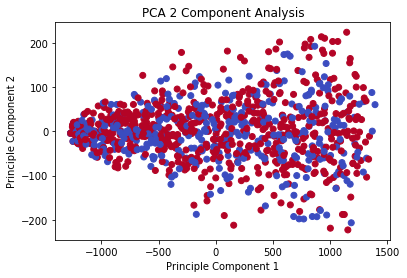

In [17]:
#Reducing to 2 Dimensions using PCA
pca = PCA(n_components=2)
principle_components = pca.fit_transform(mini_train_data1)
test_data = pca.transform(dev_data1)

#Coloring Scheme
Colors = []
for i in mini_train_labels1:
    if i == "Win":
        Colors.append(0)
    else: 
        Colors.append(1)
    
#Plotting the Data
plt.scatter(principle_components[:, 0], principle_components[:, 1], c=Colors, cmap=plt.cm.coolwarm_r)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.title("PCA 2 Component Analysis")
    

As shown above, there arent really clear clusters so PCA is probably not the best approach

In [18]:
#Gaussian Mixture Model
gmm = GMM(n_components=2, covariance_type="tied").fit(principle_components)
labels = gmm.predict(test_data)

Accuracy = []
for i in dev_labels1:
    if i == "Win":
        Accuracy.append(1)
    else:
        Accuracy.append(0)

sum(labels == Accuracy) / len(labels)

0.4739837398373984

In [19]:
#Filtering for Wins and Losses
Wins = []
Losses = []
for index in range(len(principle_components)):
    if mini_train_labels1[index] == "Win":
        Wins.append(principle_components[index])
    if mini_train_labels1[index] == "Loss":
        Losses.append(principle_components[index])
            
Wins = np.asarray(Wins)
Losses = np.asarray(Losses)
    
#Transforming test data
td = pca.transform(dev_data1)

#Wins GMM
gmm = GMM(n_components=4, covariance_type="spherical", random_state=0).fit(Wins)
predicted_labels = gmm.predict(td)
scores = gmm.score_samples(td) 
    
#Losses GMM
gmm2 = GMM(n_components=4, covariance_type="spherical", random_state=0).fit(Losses)
predicted_labels_2 = gmm2.predict(td)
scores_2 = gmm2.score_samples(td)
    
#Calculating Accuracy
label_list = []
for index in range(len(scores)):
    if scores[index] > scores_2[index]:
        label_list.append(1)
    else:
        label_list.append(0)
    
label_list = np.asarray(label_list)

accuracy = sum(label_list == Accuracy) / len(Accuracy)
print("Accuracy: ", accuracy)


Accuracy:  0.5178861788617887


#### Trying Other PreProcessing Methods

In [20]:
# Create Scaler object
scaler = preprocessing.StandardScaler()
# Fitting the data
scaled_df = scaler.fit_transform(train_data1)
scaled_test = scaler.transform(dev_data1)

In [21]:
### K Nearest Neighbors of All Features

model = KNeighborsClassifier(n_neighbors=2)
model.fit(scaled_df,train_labels1)
train_predicted_labels = model.predict(scaled_test)

print(sum(dev_labels1 == train_predicted_labels) / len(dev_labels1))


0.5203252032520326


In [22]:
lr_clf = LogisticRegression(C=100000, penalty='l1')
lr_clf.fit(scaled_df, train_labels1)
train_predicted_labels = lr_clf.predict(scaled_test)

print(sum(dev_labels1 == train_predicted_labels) / len(dev_labels1))

C:\Users\georg\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5577235772357724


### Conclusion

In [23]:
#### Iterating over Multipke Data Sets to See which has highest Individual Accuracy

datasets = [player_df, stats_df ,games_ahead_df]

for data in datasets:   
    data_matrix = np.matrix(data)
    results_df = teamBoxScore.loc[teamBoxScore['teamLoc'] == 'Home']['teamRslt']
    results_array = np.array(results_df)
    
    test_data1, test_labels1 = data_matrix[6149:], results_array[6149:]
    dev_data1, dev_labels1 = data_matrix[4919:6149], results_array[4919:6149]
    train_data1, train_labels1 = data_matrix[:4919], results_array[:4919]
    mini_train_data1, mini_train_labels1 = data_matrix[:1000], results_array[:1000]

    model = KNeighborsClassifier(n_neighbors=2)
    model.fit(mini_train_data1,mini_train_labels1)
    train_predicted_labels = model.predict(dev_data1)
    
    print(sum(dev_labels1 != train_predicted_labels) / len(dev_labels1))
    

0.526829268292683
0.5178861788617887
0.47073170731707314
